In [7]:
library(deSolve)

In [8]:
# Basic Metropolis-Hastings MCMC 
# use random walk  based proposals

# points for illustration:
# - tightness of priors, effect on posterior and dependencies
# - size of random walk variance and mixing (0.001 works OK)
# - monitoring the acceptance probabiliy

rm(list=ls())

# dynamic model integration
simulate <- function(t, state, parameters) {
  with(as.list(c(state, parameters)), {
    om <- 2*pi/365
    dP <- gamma*(1+sin(om*t))*P - lambda*P^2
    list(c(dP))})}

In [9]:
#likelihood function
loglike <- function(theta,obs)
{
  # step 1: run the model given the parameters to get state
  tobs <- obs[,1]
  yobs <- obs[,2]
  state <- c(P = 2.5)
  out <- ode(y = state, times = tobs, func = simulate, parms = theta)
  time <- out[,1]
  xhat <- out[,2]  
  # step 2: compute the likelihood ( compare state to observations)
  L <- -sum((yobs-xhat)^2)
}

In [10]:
# load in some (synthetic) observations

load("../obs.RData") # contains tobs, yobs
obs <- cbind(tobs,yobs)

In [11]:
# M-H

nc        <- 1000 # number of samples in chain
theta_acc <- array(NA,dim=c(nc,2)) # accumulator for posterior samples
thetaold  <- c(.25,.1) # initial condition for chain 

# prior info (use normal distributions)
gammabar <- 0.25 # gamma mean 
lambdabar <- 0.1 # lambda mean
gamsd <- 0.05
lamsd <- 0.02

# random walk std dev
rwsd <- 0.001

for (ic in 1:nc){
    # ** Step 1: Generate Trial Candidate  
    # use random walk based on previous value of the chain

    thetac <- thetaold + rwsd*rnorm(2)

    # Step 2: Compute acceptance probability for this candidate
    # log likelihood for for candidate/trail particle
    like_num <- loglike(c(gamma=thetac[1],lambda=thetac[2]),obs)
    pgam <- dnorm(thetac[1],gammabar,gamsd,log=T)
    plam <- dnorm(thetac[2],lambdabar,lamsd,log=T)
    prior_num <- pgam+plam 

    # log likelihood for current particle (last member of the chain/sample)
    like_denom <- loglike(c(gamma=thetaold[1],lambda=thetaold[2]),obs)
    pgam <- dnorm(thetaold[1],gammabar,gamsd,log=T)
    plam <- dnorm(thetaold[2],lambdabar,lamsd,log=T)
    prior_denom <- pgam+plam 

    # ratio of posteriors (candidate vs current)
    ratio=exp((like_num+prior_num) - (like_denom+prior_denom))

    A=min(c(1,ratio)); # acceptance probability

    # Step 3: Choose whether to accept candidate
    # accept candidate with probability A, otherwise revert to previous chain member
    u=runif(1,0,1)
    if (u<=A) {thetanew <- thetac} else {thetanew <- thetaold}

    # add result to the sample accumulator
    theta_acc[ic,] <- thetanew
    thetaold <- thetanew # make new particle the current particle for iterations
} 

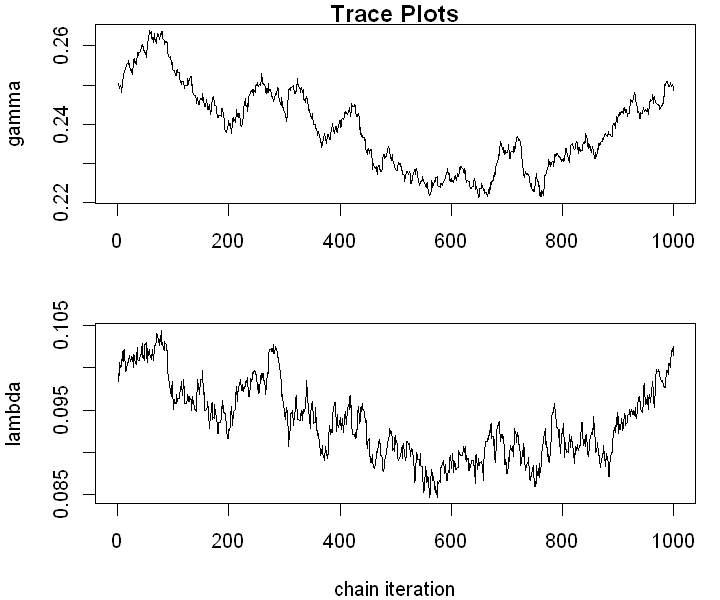

In [17]:
options(repr.plot.width=6, repr.plot.height=5)
################
# plots

# trace plots
par(mfrow=c(2,1),mar=c(4,4,1,1))
plot(theta_acc[,1], type="l", main="Trace Plots", ylab="gamma", xlab="")
plot(theta_acc[,2], type="l", xlab="chain iteration", ylab="lambda")

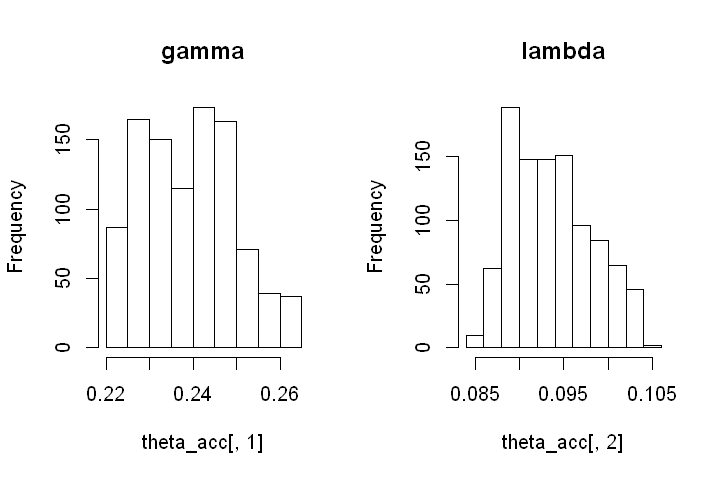

In [20]:
options(repr.plot.width=6, repr.plot.height=4)
# histograms
par(mfrow=c(1,2))
hist(theta_acc[,1], main="gamma")
hist(theta_acc[,2], main="lambda")

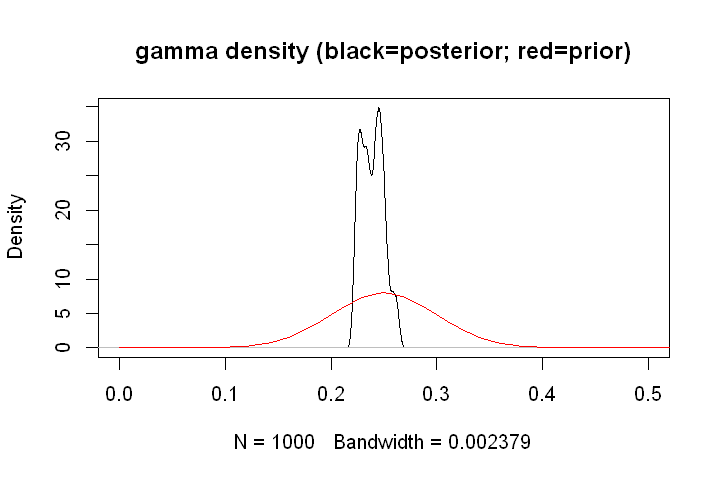

In [21]:
# posterior and prior
par(mfrow=c(1,1))
ksd_gam <- density(theta_acc[,1], kernel="triangular")
plot(ksd_gam, main="gamma density (black=posterior; red=prior)", xlim=c(0,0.5))
x <- seq(0,1,.01)
pdfx <- dnorm(x,mean=gammabar,sd=gamsd)
lines(x,pdfx,col="red")

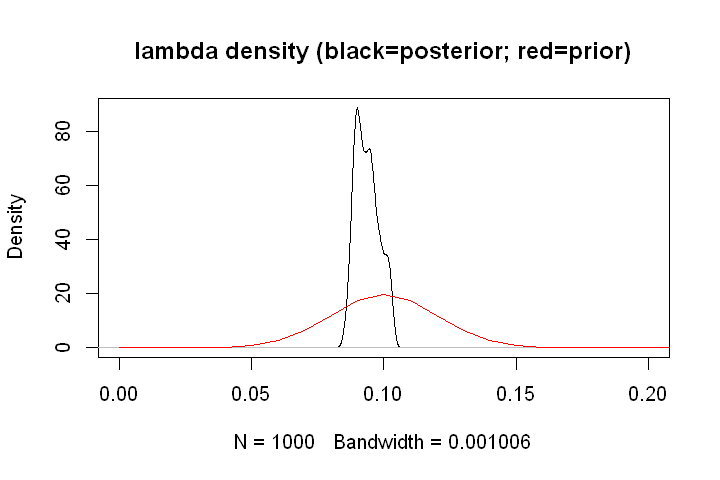

In [22]:
ksd_lam <- density(theta_acc[,2], kernel="triangular")
plot(ksd_lam, main="lambda density (black=posterior; red=prior)", xlim=c(0,0.2) )
x <- seq(0,1,.01)
pdfx <- dnorm(x,mean=lambdabar,sd=lamsd)
lines(x,pdfx,col="red")

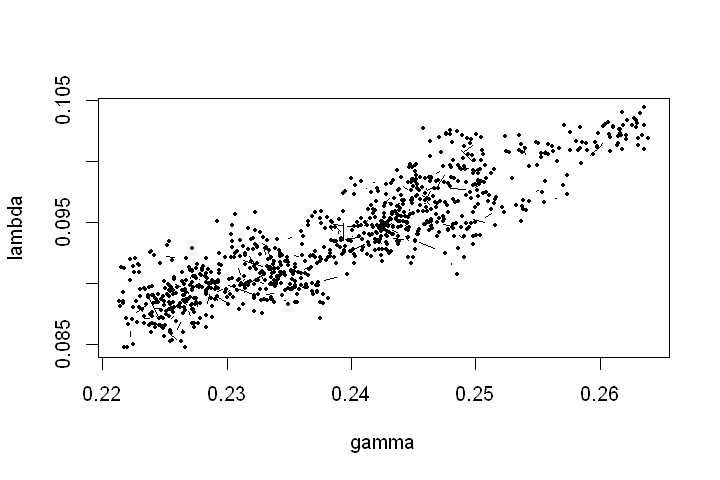

In [23]:
par(mfrow=c(1,1))
plot(theta_acc[,1], theta_acc[,2],type="b", 
     pch=19, cex=0.5, col="black", xlab="gamma", ylab="lambda")